In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import lightgbm as lgb
from lightgbm import early_stopping, plot_metric, record_evaluation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hyperopt import fmin, hp, partial, tpe, Trials
import sys
sys.path.append('../..')
from pipeline.backtest import cross_validation
import pipeline.backtest_trading as bt
from sklearn.preprocessing import KBinsDiscretizer
from visualization.trading_stat import bear_market_suite
from portfolio import Portfolio
import itertools
import talib as ta

random_state = 42

In [3]:
base_ds = xr.open_dataset('../../data/nc_2round/base.nc')
fundamental_v0_ds = xr.open_dataset('../../data/nc_2round/fundamental_v0.nc')
market_ds = xr.open_dataset('../../data/nc_2round/market_brief.nc')

ds = xr.merge([base_ds, fundamental_v0_ds, market_ds])

In [4]:
ds

<xarray.Dataset>
Dimensions:            (day: 1700, asset: 54, timeslot: 50)
Coordinates:
  * day                (day) int32 1 2 3 4 5 6 ... 1695 1696 1697 1698 1699 1700
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
  * timeslot           (timeslot) int32 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
Data variables: (12/29)
    open               (day, asset, timeslot) float64 ...
    close              (day, asset, timeslot) float64 ...
    high               (day, asset, timeslot) float64 ...
    low                (day, asset, timeslot) float64 ...
    volume             (day, asset, timeslot) float64 ...
    money              (day, asset, timeslot) float64 ...
    ...                 ...
    mean_volume        (day, asset) float64 ...
    close_0            (day, asset) float64 ...
    open_0             (day, asset) float64 ...
    high_0             (day, asset) float64 ...
    low_0              (day, asset) float64 ...
    return_0           (day, asset) float64 ...

## Feature

In [5]:
start_day = 80
end_day = 200
val_split_day = 150
_ds = ds.sel(day=slice(start_day-20, end_day)).copy()

In [6]:
start_day = 1030
end_day = 1300
val_split_day = 1250
_ds = ds.sel(day=slice(start_day-20, end_day)).copy()

In [7]:
start_day = 640
end_day = 1000
val_split_day = 900
lookback = 20
lookforward = 20
_ds = ds.sel(day=slice(start_day-lookback, end_day+lookforward)).copy()

In [8]:
# long term trend!
# ds['return50'] = (_ds['close_0'] / _ds['close_0'].shift(day=50) - 1).shift(day=-50)
# _ds['return20'] = (_ds['close_0'] / _ds['close_0'].shift(day=20) - 1).shift(day=-20)
# _ds['return10'] = (_ds['close_0'] / _ds['close_0'].shift(day=10) - 1).shift(day=-10)
# _ds['return5'] = (_ds['close_0'] / _ds['close_0'].shift(day=5) - 1).shift(day=-5)

In [9]:
def quantizer(da, n_bins, start_day, val_split_day, end_day):
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    train_bin = est.fit_transform(da.sel(day=range(start_day, val_split_day)).transpose('day', 'asset').as_numpy())
    val_bin = est.transform(da.sel(day=slice(val_split_day, end_day)).transpose('day', 'asset').as_numpy())
    return ('day', 'asset'), np.concatenate([train_bin, val_bin]).astype(int)

## fundamental feature
_ds['is_market_cap_largest'] = (_ds['market_cap'].max(dim='asset') == _ds['market_cap']).astype(int)
_ds['market_cap_bin'] = quantizer(_ds['market_cap'], 4, start_day-lookback, val_split_day, end_day+lookforward)

In [10]:
## historical features
for i in range(1, lookback+1):
    _ds[f'close 0 to {i} ratio diff'] = _ds['close_0'] / _ds['close_0'].shift(day=i) - 1


In [11]:
_ds['high_0'].to_numpy()[:, 0]

array([21.3022, 21.1444, 20.2826, 20.2705, 20.5132, 20.4404, 20.7196,
       20.671 , 20.5011, 20.756 , 20.8167, 20.6589, 20.2826, 20.5132,
       20.6953, 20.0034, 19.615 , 19.7607, 19.6514, 19.7607, 19.5179,
       19.7849, 19.8214, 19.8456, 19.9427, 19.8942, 19.967 , 19.967 ,
       19.7971, 19.53  , 20.0641, 20.3433, 20.4161, 20.4161, 20.3554,
       20.9016, 20.9259, 20.8652, 20.5739, 20.8409, 20.7317, 21.3629,
       21.9455, 21.2051, 21.1444, 21.023 , 21.2415, 21.2051, 20.7803,
       20.671 , 20.6225, 20.4283, 19.5665, 19.6514, 19.6029, 19.4815,
       19.7121, 19.8214, 19.7971, 19.6514, 19.7485, 19.7121, 19.4451,
       19.3601, 19.2387, 19.0202, 19.0202, 19.2266, 19.3116, 19.0445,
       18.9231, 18.8625, 18.2313, 18.2313, 18.0128, 17.7458, 17.6608,
       17.8064, 17.8793, 18.0007, 18.8139, 18.6925, 18.644 , 18.207 ,
       18.0856, 18.1342, 17.7579, 18.0249, 17.855 , 18.0007, 17.6851,
       17.4666, 17.151 , 17.1631, 17.0782, 17.0539, 17.1631, 16.9811,
       16.5562, 16.3

In [12]:
## technical
from collections import defaultdict
technicals = defaultdict(list)
for asset in range(54):
    h = _ds['high_0'].to_numpy()[:, asset]
    o = _ds['open_0'].to_numpy()[:, asset]
    l = _ds['low_0'].to_numpy()[:, asset]
    c = _ds['close_0'].to_numpy()[:, asset]
    
    technicals['sar'].append(ta.SAR(h, l))
    technicals['sarext'].append(ta.SAREXT(h, l))
    technicals['rsi'].append(ta.RSI(c, timeperiod=14) - 50)
    technicals['ht_dcperiod'].append(ta.HT_DCPERIOD(c))
    technicals['ht_phasor_inphasse'].append(ta.HT_DCPHASE(c))
    sc, sl = ta.HT_SINE(c)
    technicals['ht_sine_sine'].append(sc)
    technicals['ht_sine_leadsine'].append(sl)

for k, l in technicals.items():
    _ds[k] = ('asset', 'day'), np.stack(l, axis=0)
    _ds[k].fillna(_ds[k].isel(day=1))
    

In [13]:
## adding intraday feature
_ds['volume_0'] = _ds['volume'].sum(dim='timeslot')
_ds['morning_volume_ratio'] = _ds['volume'].isel(timeslot=slice(2)).sum(dim='timeslot') / _ds['volume_0']
_ds['tail_volume_ratio'] = _ds['volume'].isel(timeslot=slice(-3, -1)).sum(dim='timeslot') / _ds['volume_0']
_ds['morning_turnover'] = _ds['morning_volume_ratio'] * _ds['turnoverRatio']
_ds['tail_turnover'] = _ds['tail_volume_ratio'] * _ds['turnoverRatio']

windows = 3, 5, 10, 20
tags = 'volume_0', 'morning_volume_ratio', 'tail_volume_ratio', 'close_0', 'volatility'
for w in windows:
    for tag in tags:
        _ds[f'{tag}_moving_{w}_ratio'] = _ds[tag] / (_ds[tag].rolling(day=w).mean()+1e-6) - 1
        _ds[f'{tag}_moving_{w}_2max'] = 1 - _ds[tag] / (_ds[tag].rolling(day=w).max()+1e-6)
        _ds[f'{tag}_moving_{w}_2min'] = _ds[tag] / (_ds[tag].rolling(day=w).min()+1e-6) - 1

In [14]:
trad_features = [
    'pe', 'pe_ttm', 'pb', 'ps', 'pcf', 'turnoverRatio',
    'earnings', 'earnings_ttm', 'book', 'sales', 'cashflow',
    'volatility',
]
technicals = [
    'sar', 'sarext', 'rsi', 'ht_dcperiod', 'ht_phasor_inphasse', 'ht_sine_sine', 'ht_sine_leadsine',
]
market_cap_features = [
    'market_cap', 'is_market_cap_largest', 'market_cap_bin',
]
outstanding_features = [
    'morning_volume_ratio', 'tail_volume_ratio', 'morning_turnover', 'tail_turnover',
]
relative_features = [
    f'{tag}_moving_{w}_{pf}' for tag, w, pf in itertools.product(tags, windows, ['ratio', '2max', '2min'])
]
categorical_feature = [
    'is_market_cap_largest', 'market_cap_bin',
]

In [15]:
# features = [f'close 0 to {i} ratio diff' for i in range(1, 15)] + ['volatility']
# categorical_feature = []

features = [f'close 0 to {i} ratio diff' for i in range(1, 15)] + technicals + trad_features + outstanding_features + relative_features
categorical_feature = []

# features = [f'close 0 to {i} ratio diff' for i in range(5, 50, 5)] + ['volatility']
# categorical_feature = []

## LightGBM

In [64]:
target = 'return'
_start = val_split_day - 20
_end = val_split_day + 1

In [65]:
enable_asset = 'asset' in categorical_feature

train_df = _ds[features + [target]].sel(day=range(_start, val_split_day)).to_dataframe(dim_order=['day', 'asset'])
val_df = _ds[features + [target]].sel(day=slice(val_split_day, _end)).to_dataframe(dim_order=['day', 'asset'])
if enable_asset:
    train_df.reset_index(level='asset', inplace=True)
    val_df.reset_index(level='asset', inplace=True)
train_X, train_y = train_df[features + (['asset'] if enable_asset else [])].copy(), train_df[target].copy()
train_y_binary = (train_y > 0).astype(int)
val_X, val_y = val_df[features + (['asset'] if enable_asset else [])].copy(), val_df[target].copy()
val_y_binary = (val_y > 0).astype(int)

In [66]:
def process_extreme_values(X, y):
    for col in X:
        if col == 'asset' or col == 'close_0':
            continue
        lq, uq = X[col].quantile(5e-3), X[col].quantile(1-5e-3)
        X[col] = np.clip(X[col], lq, uq)
    ylq, yuq = y.quantile(2e-4), y.quantile(1-2e-4)
    mask = (y > ylq) & (y < yuq)
    return X.loc[mask], y.loc[mask]

train_X, train_y = process_extreme_values(train_X, train_y)
val_X, val_y = process_extreme_values(val_X, val_y)

In [67]:
train_data = lgb.Dataset(data=train_X, label=train_y, categorical_feature=categorical_feature, free_raw_data=False)
val_data = lgb.Dataset(data=val_X, label=val_y, categorical_feature=categorical_feature, free_raw_data=False)

In [78]:
from sklearn.metrics import mean_absolute_percentage_error

def mape(y_true, y_pred):
    y_true_np, y_pred_np = np.array(y_true), np.array(y_pred)
    mape_score = np.mean(np.abs(y_true_np - y_pred_np) / (np.abs(y_true_np) + 1e-4))
    return mape_score

def lgb_get_model_score_mape(model):
    prediction = model.predict(val_X, num_iteration = model.best_iteration)
    y_predicted = pd.Series(prediction)
#     print(val_y)
#     print(y_predicted)
#     raise
    return mean_absolute_percentage_error(val_y, y_predicted)
#     return mape(val_y, y_predicted)

def coerce_int(d):
    _d = {}
    for k, v in d.items():
        if isinstance(v, float):
            if np.isclose(v, int(v)):
                _d[k] = int(v)
                continue
        _d[k] = v
    return _d

def arg_aug(d, handle_int=False):
    num_boost_round = int(d['num_boost_round'])
    del d['num_boost_round']
    
    params = {
        'nthread': 6,
        'objective': 'l2',
        'feature_fraction': 0.8,
        'bagging_seed': random_state,
        'verbosity': -1,
        'metric': ['mape', 'l2'],
    }
    params.update(coerce_int(d))
    return num_boost_round, params

def lightgbm_factory(argsDict):
    num_boost_round, params = arg_aug(argsDict, handle_int=False)
    model_lgb = lgb.train(params=params, train_set=train_data, num_boost_round=num_boost_round,
                          valid_sets=[val_data],
                          categorical_feature=categorical_feature,
                          callbacks=[early_stopping(100, verbose=False)])
    return lgb_get_model_score_mape(model_lgb)

In [79]:
# Find a best model
lgb_space = {
    "max_depth": hp.uniformint("max_depth", 3, 10),
    "num_boost_round": hp.uniformint("num_boost_round", 5, 100),
    "learning_rate": hp.loguniform("learning_rate", -10, -2),
    "lambda_l1": hp.loguniform("lambda_l1", -10, 0),
    "lambda_l2": hp.loguniform("lambda_l2", -10, 0),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    "num_leaves": hp.uniformint("num_leaves", 10, 500),
    "bagging_freq": hp.uniformint("bagging_freq", 1, 10),
}
algo = partial(tpe.suggest, n_startup_jobs=1)
lgb_best = fmin(fn=lightgbm_factory, space=lgb_space, algo=algo, max_evals=200, pass_expr_memo_ctrl=None)

evals = {}
num_boost_round, lgb_best = arg_aug(lgb_best, handle_int=True)
model = lgb.train(params=lgb_best, train_set=train_data, num_boost_round=num_boost_round,
                  valid_sets=[train_data, val_data], categorical_feature=categorical_feature,
                  callbacks=[early_stopping(100, verbose=False), record_evaluation(evals)])

100%|██████████| 200/200 [00:29<00:00,  6.77trial/s, best loss: 0.926143464137165] 


<AxesSubplot: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='mape'>

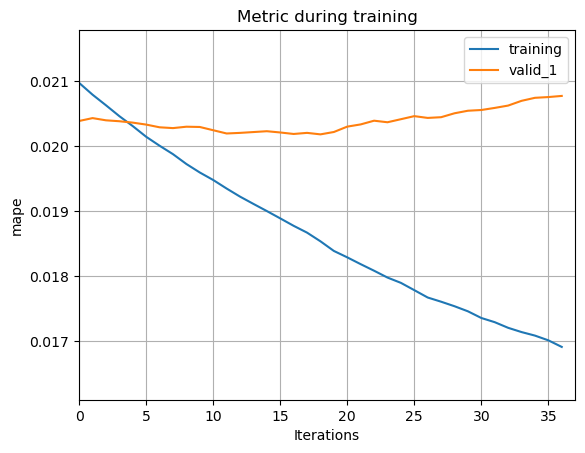

In [82]:
plot_metric(evals, 'mape')

In [83]:
y_pred = model.predict(val_X, num_iteration=model.best_iteration)

In [84]:
from sklearn.metrics import r2_score
r2_score(val_y, y_pred)

-0.40313337191580967

In [85]:
pd.Series(train_y.values).corr(pd.Series(model.predict(train_X, num_iteration=model.best_iteration)))

0.7518151943580333

In [86]:
pd.Series(val_y.values).corr(pd.Series(y_pred))

-0.03843724473029534

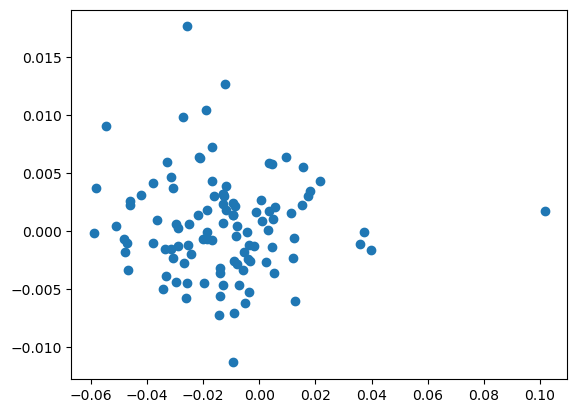

In [87]:
plt.scatter(val_y, y_pred)

In [301]:
class GBMPortfolio(Portfolio):
    def __init__(self, categorical_feature):
        self.categorical_feature = categorical_feature

    def _prepare_data(self, X, y):
        start_day = X.day.min().item()
        end_day = X.day.max().item()
        val_split_day = (start_day + end_day * 4) // 5

        train_X = X.sel(day=range(start_day, val_split_day)).to_dataframe(dim_order=['day', 'asset'])
        train_y = y.sel(day=range(start_day, val_split_day)).transpose('day', 'asset').to_series()
        train_data = lgb.Dataset(data=train_X, label=train_y, categorical_feature=self.categorical_feature, free_raw_data=False)
        
        val_X = X.sel(day=slice(val_split_day, end_day)).to_dataframe(dim_order=['day', 'asset'])
        val_y = y.sel(day=slice(val_split_day, end_day)).transpose('day', 'asset').to_series()
        val_data = lgb.Dataset(data=val_X, label=val_y, categorical_feature=self.categorical_feature, free_raw_data=False)
        
        return train_data, val_X, val_y, val_data
        
    def initialize(self, X, y):
        train_data, val_X, val_y, val_data = self._prepare_data(X, y)
        
        def mape(y_true, y_pred):
            y_true_np, y_pred_np = np.array(y_true), np.array(y_pred)
            mape_score = np.mean((y_true_np - y_pred_np) / (np.abs(y_true_np) + 1e-4))
            return mape_score

        def coerce_int(d):
            _d = {}
            for k, v in d.items():
                if isinstance(v, float):
                    if np.isclose(v, int(v)):
                        _d[k] = int(v)
                        continue
                _d[k] = v
            return _d

        def arg_aug(d):
            num_boost_round = int(d['num_boost_round'])
            del d['num_boost_round']

            params = {
                'nthread': 6,
                'objective': 'regression',
                'feature_fraction': 0.8,
                'bagging_seed': random_state,
                'verbosity': -1,
                'metric': ['mape', 'regression'],
            }
            params.update(coerce_int(d))
            return num_boost_round, params

        def lightgbm_factory(argsDict):
            num_boost_round, params = arg_aug(argsDict)
            model_lgb = lgb.train(params=params, train_set=train_data, num_boost_round=num_boost_round,
                                  valid_sets=[val_data],
                                  categorical_feature=self.categorical_feature,
                                  callbacks=[early_stopping(20, verbose=False)])
            return mape(model.predict(val_X, num_iteration = model.best_iteration), val_y)
        
        # Find a best model
        lgb_space = {
            "max_depth": hp.uniformint("max_depth", 5, 10),
            "num_boost_round": hp.uniformint("num_boost_round", 10, 100),
            "learning_rate": hp.loguniform("learning_rate", 1e-3, 1e-1),
            "lambda_l1": hp.loguniform("lambda_l1", 1e-5, 1e-1),
            "lambda_l2": hp.loguniform("lambda_l2", 1e-5, 1e-1),
            'subsample': hp.uniform('subsample', 0.5, 1.0),
            "num_leaves": hp.uniformint("num_leaves", 100, 1000),
            "bagging_freq": hp.uniformint("bagging_freq", 1, 10),
        }
        algo = partial(tpe.suggest, n_startup_jobs=1)
        lgb_best = fmin(fn=lightgbm_factory, space=lgb_space, algo=algo, max_evals=50, pass_expr_memo_ctrl=None)

        self.num_boost_round, self.lgb_best = arg_aug(lgb_best)
        self.model = lgb.train(params=self.lgb_best, train_set=train_data, num_boost_round=self.num_boost_round,
                  valid_sets=[train_data, val_data], categorical_feature=self.categorical_feature,
                  callbacks=[early_stopping(20, verbose=False)])

    def train(self, X, y):
        train_data, val_X, val_y, val_data = self._prepare_data(X, y)
        self.model = lgb.train(params=self.lgb_best, train_set=train_data, num_boost_round=self.num_boost_round,
                  valid_sets=[train_data, val_data], categorical_feature=self.categorical_feature,
                  callbacks=[early_stopping(20, verbose=False)])

    def construct(self, X):
        current_day = X.day.max().item()
        X_df = X.sel(day=[current_day]).to_dataframe(dim_order=['day', 'asset'])
        y_pred = self.model.predict(X_df, num_iteration=self.model.best_iteration)
        propose = np.clip(y_pred, 0, None)
        if propose.sum() <= 0:
            return propose
        propose /= propose.sum()
        propose[propose < 0.01] = 0
        return propose

Period (80, 200) not available in ds, skipping...
Now testing period (640, 1000):


  0%|          | 0/361 [00:00<?, ?it/s]



  0%|                                                                                                                                                                | 0/50 [00:00<?, ?trial/s, best loss=?]

 14%|██████████████████▊                                                                                                                   | 7/50 [00:00<00:00, 67.66trial/s, best loss: -2.770411988463462]

 28%|█████████████████████████████████████▏                                                                                               | 14/50 [00:00<00:00, 64.49trial/s, best loss: -2.770411988463462]

 42%|███████████████████████████████████████████████████████▊                                                                             | 21/50 [00:00<00:00, 60.94trial/s, best loss: -2.770411988463462]

 56%|██████████████████████████████████████████████████████████████████████████▍                                                          | 28/50 [00:00<00:00, 58.25trial/s, 

KeyError: "not all values found in index 'day'"

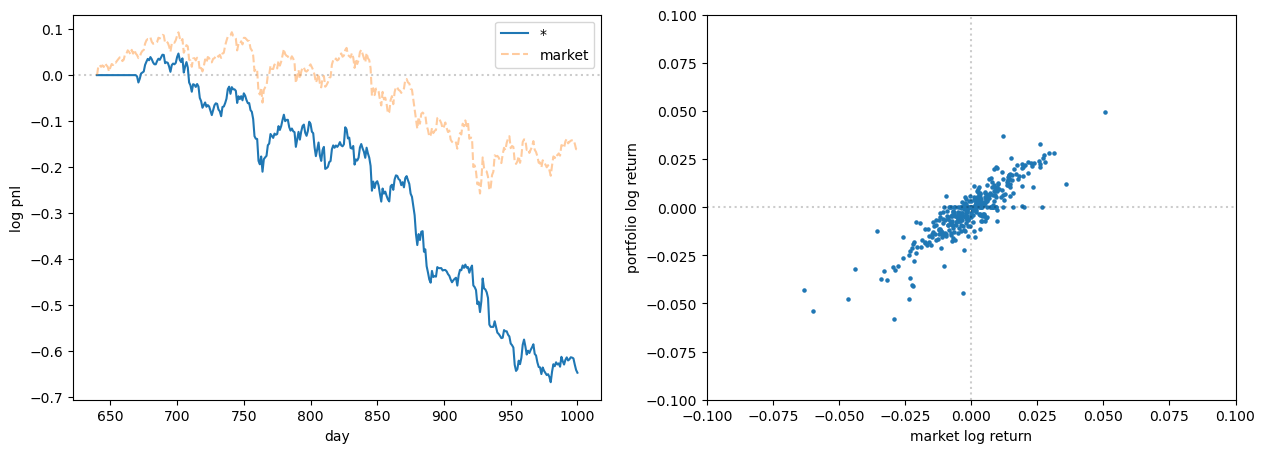

In [302]:
p = GBMPortfolio(categorical_feature)
bear_market_suite(p, features, _ds, lookback_window=50, need_full_lookback=True)

## How about classification

In [121]:
train_data_binary = lgb.Dataset(data=train_X, label=train_y_binary, categorical_feature=categorical_feature, free_raw_data=False)
val_data_binary = lgb.Dataset(data=val_X, label=val_y_binary, categorical_feature=categorical_feature, free_raw_data=False)

In [185]:
def coerce_int(d):
    _d = {}
    for k, v in d.items():
        if isinstance(v, float):
            if np.isclose(v, int(v)):
                _d[k] = int(v)
                continue
        _d[k] = v
    return _d

def arg_aug(d, handle_int=False):
    num_boost_round = int(d['num_boost_round'])
    del d['num_boost_round']
    
    params = {
        'nthread': 6,
        'objective': 'cross_entropy',
        'feature_fraction': 0.8,
        'bagging_seed': random_state,
        'verbosity': -1,
        'metric': ['cross_entropy', 'average_precision'],
    }
    params.update(coerce_int(d))
    return num_boost_round, params

from sklearn.metrics import log_loss

def lightgbm_binary_factory(argsDict):
    num_boost_round, params = arg_aug(argsDict, handle_int=False)
    model_lgb = lgb.train(params=params, train_set=train_data_binary, num_boost_round=num_boost_round,
                          valid_sets=[val_data_binary],
                          categorical_feature=categorical_feature,
                          callbacks=[early_stopping(100, verbose=False)])
    prediction = model.predict(val_X, num_iteration=model_lgb.best_iteration)
    return log_loss(val_y_binary.values, prediction)

In [190]:
# Find a best model
lgb_space = {
    "max_depth": hp.uniformint("max_depth", 5, 20),
    "num_boost_round": hp.uniformint("num_boost_round", 10, 100),
    "learning_rate": hp.loguniform("learning_rate", 1e-3, 1e-1),
    "lambda_l1": hp.loguniform("lambda_l1", 1e-5, 1e-1),
    "lambda_l2": hp.loguniform("lambda_l2", 1e-5, 1e-1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    "num_leaves": hp.uniformint("num_leaves", 50, 500),
    "bagging_freq": hp.uniformint("bagging_freq", 1, 10),
}
algo = partial(tpe.suggest, n_startup_jobs=1)
lgb_best = fmin(fn=lightgbm_binary_factory, space=lgb_space, algo=algo, max_evals=20, pass_expr_memo_ctrl=None)

evals = {}
num_boost_round, lgb_best = arg_aug(lgb_best, handle_int=True)
model_binary = lgb.train(params=lgb_best, train_set=train_data_binary, num_boost_round=num_boost_round,
                         valid_sets=[train_data_binary, val_data_binary], categorical_feature=categorical_feature,
                         callbacks=[early_stopping(100, verbose=True), record_evaluation(evals)])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.88trial/s, best loss: 9.487132652580847]
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[52]	training's cross_entropy: 0.0879307	training's average_precision: 0.998769	valid_1's cross_entropy: 2.18119	valid_1's average_precision: 0.506338


In [191]:
y_pred = model_binary.predict(val_X, num_iteration=model.best_iteration)
log_loss(val_y_binary.values, y_pred)

0.7662588131882933

In [192]:
num_boost_round

52

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='average_precision'>

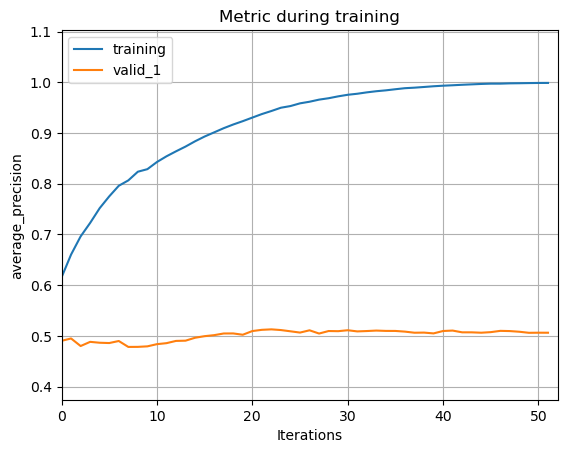

In [193]:
plot_metric(evals, 'average_precision')